## Imports and Setups

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json, time

from gan import preprocessing, tadgan, postprocessing, utils


In [2]:
# set constants and hyperparameters

DATASET = 'data/2023_quy1_fake_error.csv'
# Minimum value: 20.5
# Maximum value: 32.5
# preprocessing
RESAMPLE_FREQ = 'H'  
WINDOW_SIZE = 100

# reconstruction model (TadGAN)
LATENT_DIM = 20
ENCODER_PARAMS = {'LSTM_units': 100}
GENERATOR_PARAMS = {'LSTM_units': 64, 'LSTM_dropout': 0.2}
LEARNING_RATE = 0.0001
EPOCHS = 100

# postprocessing
RECON_SCORE_PARAMS = {'dtw_window': 10}
ANOMALOUS_SEQ_PARAMS = {'sd_threshold': 4.0, 'pad': 50}

## Load Time Series Data

In [3]:
# import time series

x = pd.read_csv(DATASET)

# x['time'] = pd.to_datetime(x['time'],format="%d-%m-%Y %H:%M:%S", dayfirst=True)
x.set_index('time', inplace=True)
x.index = pd.to_datetime(x.index)
x.sort_index(inplace=True)

print(f'Number of time stamps: {x.size}')
print(f'First 3 time stamps: {x.index[0]}, {x.index[1]}, {x.index[2]}')
print(f'Last 3 time stamps: {x.index[-3]}, {x.index[-2]}, {x.index[-1]}')

x.describe()

temp = x['temperature']
# temp = temp[temp>=18]
# temp = temp.resample('H').mean()

train = temp[(temp.index.year>=2022)]
# test = temp[(temp.index.year>2022) | ((temp.index.year==2022)&(temp.index.month>=9))]

train.head()

Number of time stamps: 10811
First 3 time stamps: 2023-01-01 00:17:01, 2023-01-01 00:19:03, 2023-01-01 00:41:58
Last 3 time stamps: 2023-03-27 20:50:42, 2023-03-27 21:14:50, 2023-03-27 21:25:27


time
2023-01-01 00:17:01    22.1
2023-01-01 00:19:03    22.9
2023-01-01 00:41:58    22.9
2023-01-01 00:43:16    21.9
2023-01-01 01:04:53    22.9
Name: temperature, dtype: float64

## Prepare Training Data


In [4]:
# apply preprocessing pipeline

train, t, x_win, t_win = preprocessing.new_apply_pipeline(train, freq=RESAMPLE_FREQ, window_size=WINDOW_SIZE)

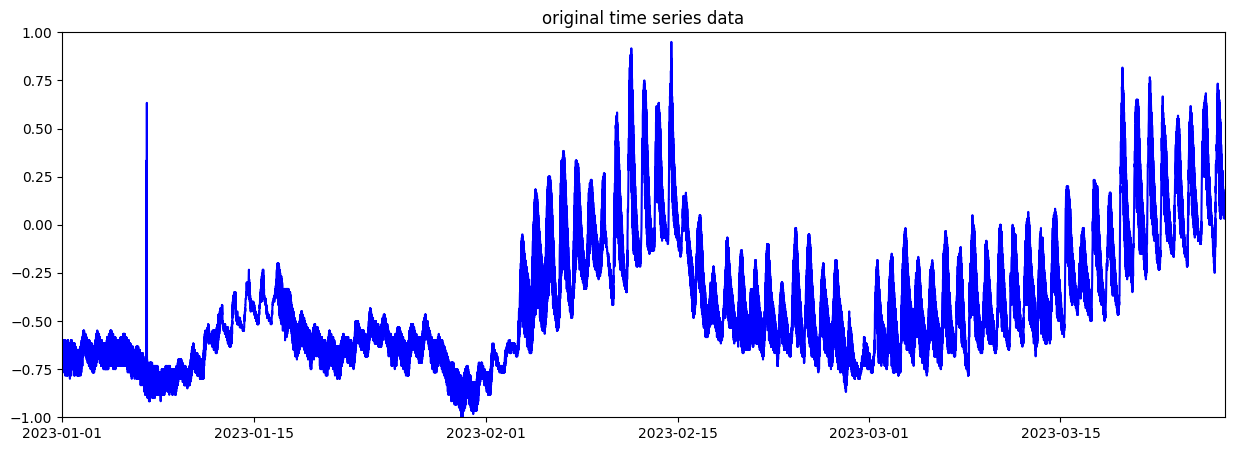

In [5]:
# plot the original time series and reconstructed segments

utils.plot_time_series(t, train, x_win=None, 
                       date_range=['2023-01-01', '2023-03-27'], value_range=[-1, 1],
                       title='original time series data')

In [6]:
print(f'Number of rolling windows: {x_win.shape[0]}')
print(f'Start times of the first 3 windows: {t_win[:3]}')

Number of rolling windows: 10712
Start times of the first 3 windows: ['2023-01-01T00:17:01.000000000' '2023-01-01T00:19:03.000000000'
 '2023-01-01T00:41:58.000000000']


## Train Reconstruction Model (TadGAN)

In [7]:
# instantiate and configure a TadGAN model

params = {
    'input_dim': WINDOW_SIZE,
    'latent_dim': LATENT_DIM,
    'learning_rate': LEARNING_RATE,
    'encoder': ENCODER_PARAMS,
    'generator': GENERATOR_PARAMS
}

model = tadgan.TadGAN(**params)

In [8]:
model.get_model("./model/model_tran_100_quy1_3m")

In [18]:
# generate reconstructed time series segments
x_win_recon, critic_scores = model.predict(x_win)
print(x_win_recon)

[[-0.71026534 -0.5124849  -0.7455304  ... -0.6810808  -0.5022909
  -0.5513635 ]
 [-0.7080201  -0.5119908  -0.74381804 ... -0.6789912  -0.49983087
  -0.5486661 ]
 [-0.7109772  -0.51268893 -0.7460777  ... -0.68157345 -0.5027154
  -0.5519001 ]
 ...
 [-0.4353652  -0.15700297 -0.3344609  ...  0.36050794  0.18533021
   0.2578543 ]
 [-0.43387964 -0.15218407 -0.33340245 ...  0.35090142  0.16720167
   0.23763977]
 [-0.4272481  -0.14709033 -0.32692868 ...  0.34566543  0.15610471
   0.22540925]]


: 

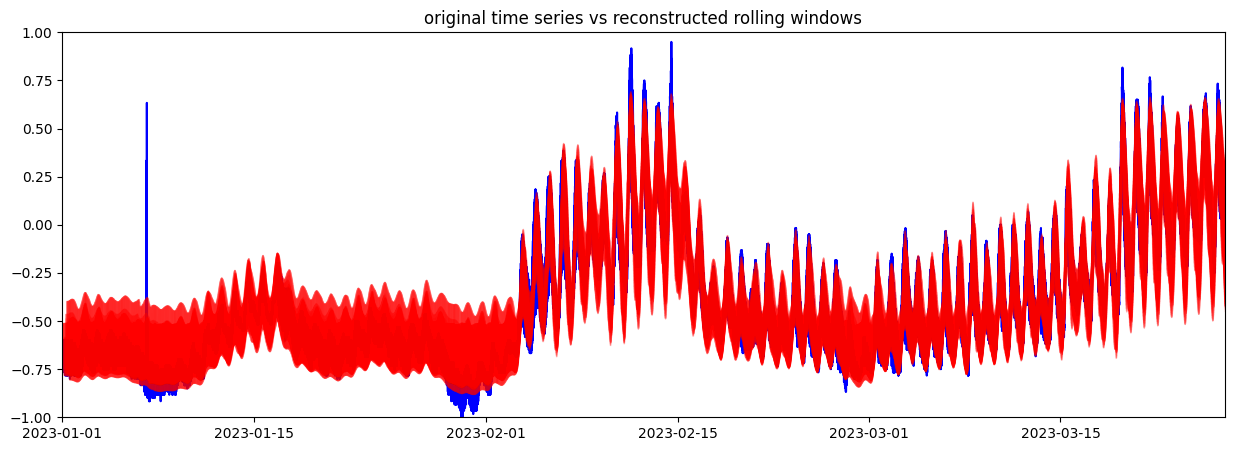

In [10]:
# plot the original time series and reconstructed segments

utils.plot_time_series(t, train, x_win=x_win_recon, 
                       date_range=['2023-01-01', '2023-03-27'], value_range=[-1, 1],
                       title='original time series vs reconstructed rolling windows')

In [11]:
# apply postprocessing pipeline to obtain anomalous intervals

params = {
    'recon_score_params': RECON_SCORE_PARAMS,
    'anomalous_seq_params': ANOMALOUS_SEQ_PARAMS
}

detected_intervals, _, _ = postprocessing.apply_pipeline(train, t, x_win_recon, critic_scores, **params)
print(detected_intervals)
detected_intervals = detected_intervals[['start', 'end']].to_numpy()

[-0.71026534 -0.6102525  -0.7109772  ...  0.25785431  0.19687224
  0.22540925]
                start                 end      score
0 2023-01-06 17:20:39 2023-01-07 15:51:37  12.214416
1 2023-02-06 02:13:53 2023-02-06 22:00:51   4.006461
2 2023-02-11 05:52:35 2023-02-12 03:20:12   8.356626
3 2023-03-27 05:34:06 2023-03-27 21:25:27   4.171982


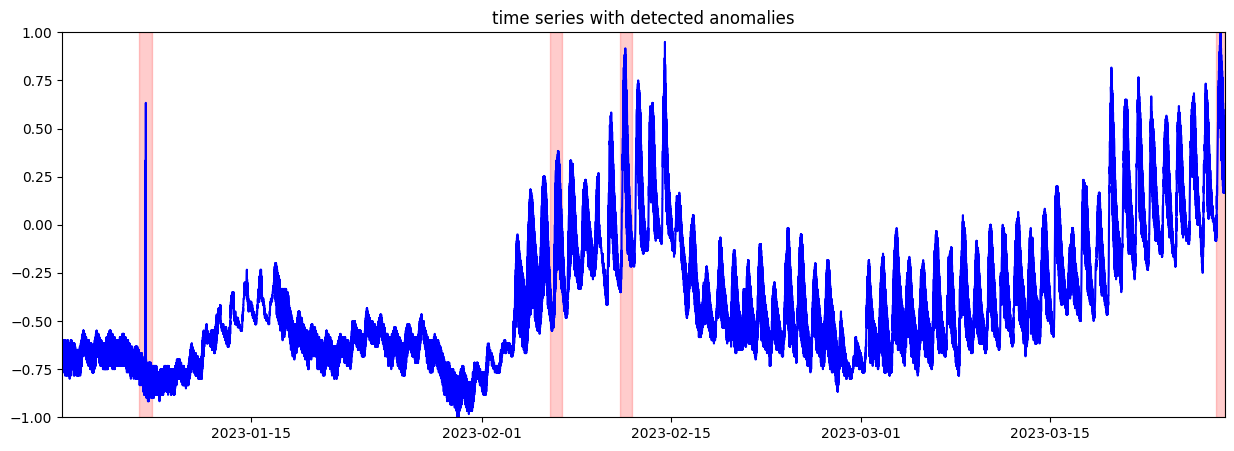

In [12]:
# plot time series with detected anomalies

utils.plot_time_series(t, train, detected_intervals=detected_intervals,
                       value_range=[-1, 1], title='time series with detected anomalies')

In [17]:
x_reconstructed_scaled = preprocessing.inverse_rolling_windows(x_win_recon)
x_reconstructed = preprocessing.inverse_scale_data(x_reconstructed_scaled)

print('x_reconstructed',x_reconstructed)

x_reconstructed [-0.71026534 -0.6102525  -0.7109772  ...  0.25785431  0.19687224
  0.22540925]
